Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
import glob

import concurrent.futures
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


UnZip the file

In [ ]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/gdrive/MyDrive/yoga/yoga pose/Test-20210722T143452Z-001.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
Test/tree/00000056.jpg                         2020-10-13 20:49:08        28887
Test/tree/00000059.jpg                         2020-10-13 20:49:08       265788
Test/tree/00000049.jpg                         2020-10-13 20:49:08        92873
Test/tree/00000065.jpg                         2020-10-13 20:49:08        57968
Test/tree/00000069.jpg                         2020-10-13 20:49:08        22129
Test/tree/00000058.jpg                         2020-10-13 20:49:08        31767
Test/tree/00000055.jpg                         2020-10-13 20:49:08        83086
Test/tree/00000053.jpg                         2020-10-13 20:49:08        43230
Test/tree/00000063.jpg                         2020-10-13 20:49:08        33195
Test/tree/00000064.jpg                         2020-10-13 20:49:08       176796
Test/tree/00000051.png                         2020-10-13 20:49:08       117038
Test/tree/00000062.jpg                  

In [5]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 14})

# Model paths: single person pose classification
model_path = 'https://tfhub.dev/google/movenet/singlepose/thunder/3'  # Larger version
model_path_light = 'https://tfhub.dev/google/movenet/singlepose/lightning/3'  # Lighter version



# Directory containing 107 subfolders with images
data_directory_path = '/content/Test'

# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 256
IMG_SIZE_LIGHT = 192
BATCH_SIZE = 32



In [6]:
kp_descriptions = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

Function Defination

In [46]:
def get_image(path: str, flip=False) -> tf.Tensor:
    """Function loads image from a file and resizes it.
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with resized image data
    """
    image = tf.expand_dims(tf.compat.v1.image.decode_jpeg(
        tf.io.read_file(path), channels=3), axis=0)
    if flip:
        image = tf.image.flip_left_right(image)
    # Resize and pad the image to keep the aspect ratio and fit the expected size
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE_LIGHT, IMG_SIZE_LIGHT), dtype=tf.int32)
    return image


def configure_for_performance(ds: tf.data.Dataset) -> tf.data.Dataset:
    """Function applies batch() and prefetch() functions
    to the dataset to optimize data processing.
    :param ds: TensorFlow Dataset object
    :return Batched TensorFlow Dataset object
    """
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE).cache()
    return ds


def movenet_inference(model: tf.keras.Model, path: str, flip=False) -> tf.Tensor:
    """Function transforms an image to a tensor of shape [1, 17, 3]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with data for 17 keypoints
    """
    keypoints = model.inference_fn(get_image(path, flip))[0]
    return keypoints


def movenet_inference_flat(model: tf.keras.Model, path: str, flip=False) -> np.array:
    """Function transforms an image to a numpy array shape [51,]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: 1D array with 51 values
    """
    keypoints = model.inference_fn(get_image(path, flip))[0][0].numpy().flatten()
    return keypoints


def movenet_serving(model: tf.keras.Model, path: str, flip=False) -> tf.Tensor:
    """Function transforms an image to a tensor of shape [1, 17, 3]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: Movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with data for 17 keypoints
    """
    keypoints = model(get_image(path, flip))['output_0'][0]
    return keypoints


def movenet_serving_flat(model: tf.keras.Model, path: str, flip=False) -> np.array:
    """Function transforms an image to a numpy array shape [51,]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: Movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: 1D array with 51 values
    """
    keypoints = model(get_image(path, flip))['output_0'][0][0].numpy().flatten()
    return keypoints


def display_images():
    """Function displays 100 examples of images
    belonging to different classes in 5 x 5 grids.
    """
    nrows = ncols = 5
    class_n = 0

    for pose in classes_df['pose'].unique():

        if class_n > 100:
            break

        class_n += 1

        if class_n % 25 == 1:
            fig = plt.gcf()
            fig.set_size_inches(ncols * 2.7, nrows * 2.7)

        image_path = classes_df[classes_df['pose'] == pose]['path'].iloc[0]
        image = mpimg.imread(image_path)
        plt.subplot(nrows, ncols, class_n % 25 + 1)
        plt.imshow(image)
        plt.axis('Off')
        plt.title(pose)

        if class_n % 25 == 1 and class_n != 1:
            plt.show()


def display_keypoints(path: str, points: tf.Tensor):
    """Function displays an image with marked keypoints.
    :param path: Path to the image file
    :param points: Tensor of keypoints in the shapes of [17, 3],
    where 0-th column contains y coordinates, 1st column - x coordinates,
    2nd column - confidence score
    """
    # Convert coordinates from range [0, 1] to absolute positions
    y = points[:, 0] * IMG_SIZE_LIGHT
    x = points[:, 1] * IMG_SIZE_LIGHT

    # Read image from file and resize with padding
    image = tf.compat.v1.image.decode_jpeg(tf.io.read_file(path), channels=3)
    image = tf.image.resize_with_pad(image, IMG_SIZE_LIGHT, IMG_SIZE_LIGHT)
    image = tf.cast(image, dtype=tf.uint8)

    plt.imshow(image)
    plt.scatter(x, y)
    plt.axis('Off')
    plt.show()


def distance(coordinates: np.array) -> tuple:
    """Function calculates distance between two keypoints
    described by x and y coordinates relative to image size.
    :param coordinates: Array with 4 values [x coordinate of the 1st keypoint,
    y coordinate of the 1st keypoint, x coordinate of the 2nd keypoint,
    y coordinate of the 2nd keypoint]
    :return: Tuple with 3 values [Euclidean distance between two points,
    distance between x coordinates, distance between y coordinates]
    """
    x_1, y_1, x_2, y_2 = coordinates
    hor_dist = abs(x_1 - x_2)
    vert_dist = abs(y_1 - y_2)
    dist = np.sqrt(hor_dist ** 2 + vert_dist ** 2)
    return dist, hor_dist, vert_dist


def is_higher(coordinates: np.array) -> int:
    """Function identifies relative positions
    of two y coordinates in vertical direction.
    :param coordinates: Array with 2 values [y coordinate of the 1st keypoint,
    y coordinate of the 2nd keypoint]
    :return: Binary value (1 - if the 1st coordinate is higher than 2nd,
    0 - if the 1st coordinate is lower than 2nd coordinate)
    """
    y_1, y_2 = coordinates
    res = int((y_1 - y_2) > 0)
    return res


def add_pos_features(df: pd.DataFrame, drop_scores=False) -> pd.DataFrame:
    """Function creates positional features based on keypoints.
    :param df: DataFrame with keypoints (x and y coordinates)
    :param drop_scores: Optional argument specifying whether to drop confidence scores
    :return: Updated DataFrame
    """
    # Distance between left and right points in pairs of limbs
    # relative to image size (Euclidean, horizontal and vertical)
    for point_type in ('elbow', 'wrist', 'knee', 'ankle'):
        d = np.apply_along_axis(
            distance, 1, df[[
                f'left_{point_type}_x', f'left_{point_type}_y',
                f'right_{point_type}_x', f'right_{point_type}_y'
            ]].values)
        df[f'{point_type}s_dist'], df[f'{point_type}s_hor_dist'], \
        df[f'{point_type}s_vert_dist'] = d.transpose()

    # Distance between specific keypoint pairs
    for point_1, point_2 in [('wrist', 'ankle'), ('wrist', 'knee'),
                             ('wrist', 'hip'), ('wrist', 'elbow'),
                             ('wrist', 'shoulder'), ('wrist', 'ear'),
                             ('ankle', 'hip'), ('ankle', 'ear'),
                             ('elbow', 'knee'), ('knee', 'hip')]:
        for side_1 in ('left', 'right'):
            for side_2 in ('left', 'right'):
                d = np.apply_along_axis(
                    distance, 1, df[[
                        f'{side_1}_{point_1}_x', f'{side_1}_{point_1}_y',
                        f'{side_2}_{point_2}_x', f'{side_2}_{point_2}_y'
                    ]].values)
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_dist'], \
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_hor_dist'], \
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_vert_dist'] = d.transpose()

    # Relative upper / lower positions of specific keypoints (binary values: 0/1)
    for point_1, point_2 in combinations(['ear', 'hip', 'knee', 'ankle', 'wrist', 'elbow'], 2):
        for side_1 in ('left', 'right'):
            for side_2 in ('left', 'right'):
                df[f'{side_1}_{point_1}_{side_2}_{point_2}'] = np.apply_along_axis(
                    is_higher, 1, df[[
                        f'{side_1}_{point_1}_y', f'{side_2}_{point_2}_y'
                    ]].values)

    if drop_scores:
        columns = filter(lambda x: x.find('score') == -1, df.columns)
        df = df[columns]

    print('Positional features added. DataFrame shape:', df.shape)

    return df






def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    # Losses and metrics
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['sparse_categorical_accuracy']
    val_acc = hist.history['val_sparse_categorical_accuracy']

    # Epochs to plot along x axis
    x_axis = range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    ax1.plot(x_axis, loss, 'bo', label='Training')
    ax1.plot(x_axis, val_loss, 'ro', label='Validation')
    ax1.set_title('Categorical crossentropy')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(x_axis, acc, 'bo', label='Training')
    ax2.plot(x_axis, val_acc, 'ro', label='Validation')
    ax2.set_title('Categorical accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()



In [47]:
#Create a DataFrame with 3 columns: image path, class name and class label
image_paths = glob.glob(f'{data_directory_path}/*/*.*')
classes_df = pd.DataFrame({'path': list(image_paths)})
classes_df['pose'] = classes_df['path'].apply(lambda x: x.split('/')[-2])
classes_df['label'] = LabelEncoder().fit_transform(classes_df['pose'])
print(f'DataFrame shape: {classes_df.shape}')
print(classes_df.head())


DataFrame shape: (470, 3)
                                 path     pose  label
0  /content/Test/goddess/00000082.jpg  goddess      1
1  /content/Test/goddess/00000060.jpg  goddess      1
2  /content/Test/goddess/00000056.jpg  goddess      1
3  /content/Test/goddess/00000052.jpg  goddess      1
4  /content/Test/goddess/00000003.jpg  goddess      1


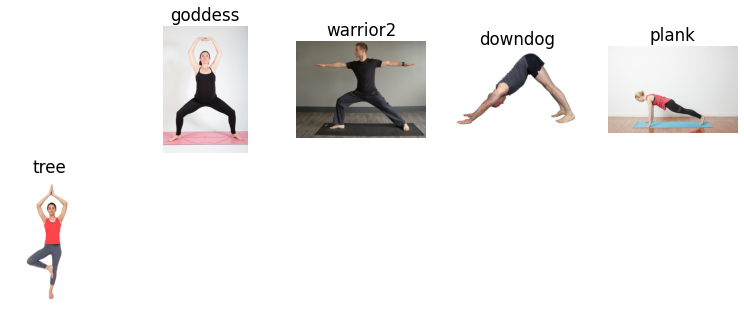

In [49]:
# Display examples of images
display_images()

In [50]:
hub_model = hub.load(model_path_light)
movenet = hub_model.signatures['serving_default']

In [51]:
example_path = classes_df['path'][0]
example_image = get_image(example_path)
outputs = movenet(example_image)
print(outputs)

{'output_0': <tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[0.24168634, 0.48963892, 0.779674  ],
         [0.23224664, 0.50463897, 0.67943215],
         [0.231836  , 0.47444236, 0.6008601 ],
         [0.25744244, 0.5227222 , 0.6632769 ],
         [0.26257718, 0.45063335, 0.8558693 ],
         [0.32109597, 0.55380404, 0.8761698 ],
         [0.32837528, 0.4264508 , 0.85695165],
         [0.20436971, 0.6058769 , 0.7368477 ],
         [0.20092684, 0.38126203, 0.8022048 ],
         [0.09874439, 0.5350008 , 0.7515712 ],
         [0.09732993, 0.44612306, 0.70538414],
         [0.5791855 , 0.54505295, 0.7335821 ],
         [0.5810286 , 0.44269967, 0.7357811 ],
         [0.6864142 , 0.70688987, 0.9345882 ],
         [0.6928811 , 0.28971323, 0.84185815],
         [0.84831893, 0.7123922 , 0.9049926 ],
         [0.8550657 , 0.27613783, 0.93200195]]]], dtype=float32)>}


In [52]:
# Output is a dictionary with [1, 1, 17, 3] tensor.
# For each image the model extracts 17 keypoints: y and x coordinates and confidence level.
keypoints = outputs['output_0']
print(keypoints)

tf.Tensor(
[[[[0.24168634 0.48963892 0.779674  ]
   [0.23224664 0.50463897 0.67943215]
   [0.231836   0.47444236 0.6008601 ]
   [0.25744244 0.5227222  0.6632769 ]
   [0.26257718 0.45063335 0.8558693 ]
   [0.32109597 0.55380404 0.8761698 ]
   [0.32837528 0.4264508  0.85695165]
   [0.20436971 0.6058769  0.7368477 ]
   [0.20092684 0.38126203 0.8022048 ]
   [0.09874439 0.5350008  0.7515712 ]
   [0.09732993 0.44612306 0.70538414]
   [0.5791855  0.54505295 0.7335821 ]
   [0.5810286  0.44269967 0.7357811 ]
   [0.6864142  0.70688987 0.9345882 ]
   [0.6928811  0.28971323 0.84185815]
   [0.84831893 0.7123922  0.9049926 ]
   [0.8550657  0.27613783 0.93200195]]]], shape=(1, 1, 17, 3), dtype=float32)


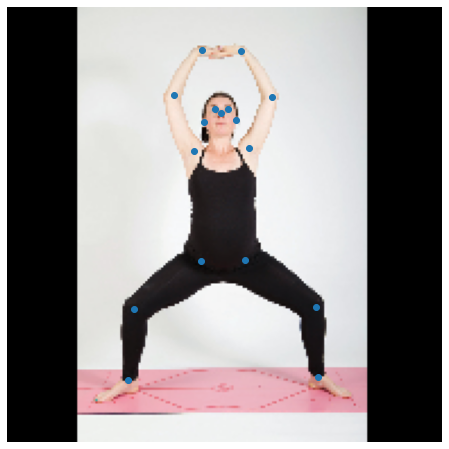

In [53]:
# Display keypoints superimposed on the image
display_keypoints(path=example_path, points=keypoints[0][0])

In [54]:
print(hub_model.inference_fn(example_image))

tf.Tensor(
[[[[0.24168634 0.48963892 0.779674  ]
   [0.23224664 0.50463897 0.67943215]
   [0.231836   0.47444236 0.6008601 ]
   [0.25744244 0.5227222  0.6632769 ]
   [0.26257718 0.45063335 0.8558693 ]
   [0.32109597 0.55380404 0.8761698 ]
   [0.32837528 0.4264508  0.85695165]
   [0.20436971 0.6058769  0.7368477 ]
   [0.20092684 0.38126203 0.8022048 ]
   [0.09874439 0.5350008  0.7515712 ]
   [0.09732993 0.44612306 0.70538414]
   [0.5791855  0.54505295 0.7335821 ]
   [0.5810286  0.44269967 0.7357811 ]
   [0.6864142  0.70688987 0.9345882 ]
   [0.6928811  0.28971323 0.84185815]
   [0.84831893 0.7123922  0.9049926 ]
   [0.8550657  0.27613783 0.93200195]]]], shape=(1, 1, 17, 3), dtype=float32)


In [55]:
# We can convert model output into a 1D array with 51 columns
# representing triplets of values: x, y, confidence
print(hub_model.inference_fn(example_image)[0][0].numpy().flatten())

[0.24168634 0.48963892 0.779674   0.23224664 0.50463897 0.67943215
 0.231836   0.47444236 0.6008601  0.25744244 0.5227222  0.6632769
 0.26257718 0.45063335 0.8558693  0.32109597 0.55380404 0.8761698
 0.32837528 0.4264508  0.85695165 0.20436971 0.6058769  0.7368477
 0.20092684 0.38126203 0.8022048  0.09874439 0.5350008  0.7515712
 0.09732993 0.44612306 0.70538414 0.5791855  0.54505295 0.7335821
 0.5810286  0.44269967 0.7357811  0.6864142  0.70688987 0.9345882
 0.6928811  0.28971323 0.84185815 0.84831893 0.7123922  0.9049926
 0.8550657  0.27613783 0.93200195]


In [56]:
# Convert all images into keypoints tensors of shape [51,] and create a list
start = time.perf_counter()
keypoints = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_inference_flat, hub_model, path) for path in classes_df['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

keypoints_df = pd.DataFrame(keypoints)
print('Original keypoints extracted. Shape:', keypoints_df.shape)



470it [00:20, 23.14it/s]

Finished in 20.46 second(s).
Original keypoints extracted. Shape: (470, 51)


In [18]:
#Flipped images
start = time.perf_counter()
keypoints_fl = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_inference_flat, hub_model, path, True) for path in classes_df['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints_fl.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

# Create a matrix of all keypoints n_samples x 51 columns
keypoints_fl = np.vstack([keypoints + keypoints_fl])
keypoints_fl_df = pd.DataFrame(keypoints_fl)
print('Original and flipped keypoints extracted. Shape:', keypoints_fl_df.shape)

470it [00:25, 18.08it/s]

Finished in 26.14 second(s).
Original and flipped keypoints extracted. Shape: (940, 51)


In [19]:
# Rename columns in the DataFrames according to the values
columns = []
for point in kp_descriptions:
    for value in ('y', 'x', 'score'):
        columns.append(f'{point}_{value}')

keypoints_df.columns = columns
keypoints_fl_df.columns = columns
print(keypoints_df.head())

     nose_y    nose_x  ...  right_ankle_x  right_ankle_score
0  0.241686  0.489639  ...       0.276138           0.932002
1  0.428004  0.507640  ...       0.376981           0.717146
2  0.214819  0.535717  ...       0.316377           0.912192
3  0.465876  0.775800  ...       0.252600           0.397556
4  0.305628  0.499608  ...       0.309783           0.669106

[5 rows x 51 columns]


In [20]:
keypoints_df = add_pos_features(keypoints_df, drop_scores=True)
keypoints_fl_df = add_pos_features(keypoints_fl_df, drop_scores=True)
print(keypoints_df.head())

Positional features added. DataFrame shape: (470, 226)
Positional features added. DataFrame shape: (940, 226)
     nose_y    nose_x  ...  right_wrist_left_elbow  right_wrist_right_elbow
0  0.241686  0.489639  ...                       0                        0
1  0.428004  0.507640  ...                       0                        0
2  0.214819  0.535717  ...                       0                        0
3  0.465876  0.775800  ...                       0                        1
4  0.305628  0.499608  ...                       0                        0

[5 rows x 226 columns]


In [44]:
keypoints_df['label'] = classes_df['label'].values

# Add 2 sets of target values - for original and flipped images
keypoints_fl_df['label'] = np.hstack(
    [classes_df['label'].values, classes_df['label'].values]
)

# Save the data for future use
keypoints_df.to_csv('keypoints.csv', index=False)
keypoints_fl_df.to_csv('keypoints_fl.csv', index=False)

In [45]:
y = keypoints_df.pop('label')
y_fl = keypoints_fl_df.pop('label')
n_features = len(keypoints_df.columns)

# Split keypoints data and labels into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    keypoints_df, y,
    stratify=y, test_size=0.2
)

x_train_fl, x_valid_fl, y_train_fl, y_valid_fl = train_test_split(
    keypoints_fl_df, y_fl,
    stratify=y_fl, test_size=0.2
)
print(x_train)
print(x_valid)

       nose_y    nose_x  ...  right_wrist_left_elbow  right_wrist_right_elbow
282  0.430621  0.817662  ...                       1                        1
329  0.473780  0.837290  ...                       1                        1
260  0.632198  0.347041  ...                       1                        1
406  0.315392  0.519860  ...                       0                        0
344  0.605811  0.306041  ...                       0                        0
..        ...       ...  ...                     ...                      ...
378  0.533896  0.140675  ...                       1                        1
14   0.462711  0.505813  ...                       1                        1
220  0.595190  0.652296  ...                       1                        1
8    0.179286  0.529541  ...                       0                        0
359  0.459243  0.677607  ...                       0                        0

[376 rows x 226 columns]
       nose_y    nose_x  ...  right_wr

SVM Classifier

In [36]:
from sklearn import svm

#Create a svm Classifier
#clf = svm.SVC(kernel='poly', degree=8) 
clf = svm.SVC(kernel='rbf')# Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_valid)

In [37]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?

print("Training Accuracy :", clf.score(x_train, y_train))
print("Testing Accuracy :", clf.score( x_valid, y_valid))

Training Accuracy : 0.9202127659574468
Testing Accuracy : 0.925531914893617


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

[[16  0  1  0  2]
 [ 0 15  0  0  1]
 [ 1  0 22  0  0]
 [ 0  0  0 14  0]
 [ 1  0  1  0 20]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       1.00      0.94      0.97        16
           2       0.92      0.96      0.94        23
           3       1.00      1.00      1.00        14
           4       0.87      0.91      0.89        22

    accuracy                           0.93        94
   macro avg       0.94      0.93      0.93        94
weighted avg       0.93      0.93      0.93        94



In [31]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly') # Linear Kernel

#Train the model using the training sets
clf.fit(x_train_fl, y_train_fl)

#Predict the response for test dataset
y_pred = clf.predict(x_valid_fl)

In [32]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_valid_fl, y_pred))


Accuracy: 0.9414893617021277


Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = rf.predict(x_valid)

print("Training Accuracy :", clf.score(x_train, y_train))
print("Testing Accuracy :", clf.score( x_valid, y_valid))


Training Accuracy : 0.9441489361702128
Testing Accuracy : 0.9468085106382979


In [38]:
rf1 = RandomForestClassifier()
rf1.fit(x_train_fl, y_train_fl)

#Predict the response for test dataset
y_pred = rf1.predict(x_valid_fl)
print(confusion_matrix(y_valid_fl, y_pred))
print(classification_report(y_valid_fl, y_pred))


[[37  0  1  0  1]
 [ 0 28  0  0  4]
 [ 0  0 46  0  0]
 [ 0  0  2 26  0]
 [ 1  2  0  0 40]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        39
           1       0.93      0.88      0.90        32
           2       0.94      1.00      0.97        46
           3       1.00      0.93      0.96        28
           4       0.89      0.93      0.91        43

    accuracy                           0.94       188
   macro avg       0.95      0.94      0.94       188
weighted avg       0.94      0.94      0.94       188

